In [100]:
"""
Load Shohei Ohtani’s 2023 Statcast batting data from the MLB database via the pybaseball API
This cell sets up the analysis by importing required libraries and pulling raw pitch-level data for the full season
The data will be used to analyze swing tendencies across pitch types and pitch counts
"""

# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

# Import Statcast data functions
from pybaseball import statcast_batter

# Configure display settings
%matplotlib inline
sns.set(style="whitegrid")

# Define Shohei Ohtani's player ID
ohtani_id = 660271

# Load 2023 Statcast batting data
batting_data = statcast_batter('2023-03-01', '2023-10-01', ohtani_id)

Gathering Player Data


In [101]:
"""
Engineer new features to categorize pitch types, identify swing types, and calculate chase/whiff behavior.
Adds:
- Pitch types labels (e.g., Fastballs)
- A human-readable pitch count string (e.g., "2-1")
- Boolean flags for swing attempts, whiffs (misses), and chases (swings at pitches outside the strike zone)
These features are used later for grouped analysis and heatmap visualizations by pitch group and count
"""

# Map pitch types to custom pitch groups
def get_pitch_group(ptype):
    if ptype in ['FF', 'SI', 'FC']:
        return 'Fastballs'
    elif ptype in ['SL', 'CU', 'KC', 'SV', 'ST']:
        return 'Breaking Balls'
    elif ptype in ['CH', 'FS', 'FO']:
        return 'Off-Speed'
    else:
        return 'Other'

batting_data['pitch_group'] = batting_data['pitch_type'].apply(get_pitch_group)

# Create count string (e.g. "2-1")
batting_data['count'] = batting_data['balls'].astype(str) + '-' + batting_data['strikes'].astype(str)

# Flag swing attempts
swing_descriptions = ['swinging_strike', 'swinging_strike_blocked', 'foul', 'foul_tip', 'hit_into_play']
batting_data['is_swing'] = batting_data['description'].isin(swing_descriptions)

# Flag whiffs (missed swings)
whiff_descriptions = ['swinging_strike', 'swinging_strike_blocked']
batting_data['is_whiff'] = batting_data['description'].isin(whiff_descriptions)

# Flag pitches outside the strike zone
batting_data['is_outside_zone'] = batting_data['zone'].isin([10, 11, 12, 13, 14])

# Flag chase swings (swing at pitch outside zone)
batting_data['is_chase'] = batting_data['is_swing'] & batting_data['is_outside_zone']

In [97]:
"""
Creates a matrix showing chase rate (swings at pitches outside the strike zone) by pitch type and pitch count
Filters to out-of-zone pitches and calculates the chase rate for each pitch group across all counts, including a 'Total' column for overall chase rate regardless of count
Filters out low-sample cells (fewer than 5 pitches) to maintain statistical validity
Result is used in a heatmap to visualize plate discipline tendencies by pitch type and situation
"""

# Filter to out-of-zone pitches
chase_df = batting_data[batting_data['is_outside_zone']]

# Group by pitch group and count
chase_grouped = chase_df.groupby(['pitch_group', 'count']).agg(
    total=('is_outside_zone', 'count'),
    chases=('is_chase', 'sum')
).reset_index()

# Keep rows with minimum 5 total pitches
chase_grouped = chase_grouped[chase_grouped['total'] >= 5]
chase_grouped['chase_rate'] = chase_grouped['chases'] / chase_grouped['total']

# Aggregate chase rate across all pitch types by count
all_chase_grouped = chase_df.groupby('count').agg(
    total=('is_outside_zone', 'count'),
    chases=('is_chase', 'sum')
).reset_index()
all_chase_grouped['pitch_group'] = 'All Pitch Types'
all_chase_grouped['chase_rate'] = all_chase_grouped['chases'] / all_chase_grouped['total']
all_chase_grouped = all_chase_grouped[all_chase_grouped['total'] >= 5]

# Combine specific and overall pitch group stats
combined_chase = pd.concat([
    chase_grouped[['pitch_group', 'count', 'chase_rate']],
    all_chase_grouped[['pitch_group', 'count', 'chase_rate']]
])
chase_matrix = combined_chase.pivot(index='pitch_group', columns='count', values='chase_rate')

# Calculate count-agnostic chase rates (Total column)
chase_totals = chase_df.groupby('pitch_group').agg(
    total=('is_outside_zone', 'count'),
    chases=('is_chase', 'sum')
)
chase_totals = chase_totals[chase_totals['total'] >= 5]
chase_totals['chase_rate'] = chase_totals['chases'] / chase_totals['total']

# Add total row for all pitch types
all_chase_total = pd.Series({
    'total': chase_df['is_outside_zone'].count(),
    'chases': chase_df['is_chase'].sum()
})
if all_chase_total['total'] >= 5:
    chase_totals.loc['All Pitch Types'] = {
        'total': all_chase_total['total'],
        'chases': all_chase_total['chases'],
        'chase_rate': all_chase_total['chases'] / all_chase_total['total']
    }

# Append total column to matrix
chase_matrix['Total'] = chase_totals['chase_rate']
chase_matrix = chase_matrix.drop(index='Other', errors='ignore')
chase_matrix = chase_matrix.reindex(['Fastballs', 'Breaking Balls', 'Off-Speed', 'All Pitch Types'])

In [98]:
"""
Creates a matrix showing whiff rate (swings and misses) by pitch type and pitch count
Filters to pitches where a swing occurred and calculates the whiff rate for each pitch group and count combination
Also includes a 'Total' column representing the overall whiff rate regardless of count
Filters out low-sample cells to ensure reliability
Output is used to visualize which pitch types and counts produce the most swings and misses
"""

# Filter to swing attempts
whiff_df = batting_data[batting_data['is_swing']]

# Group by pitch group and count
whiff_grouped = whiff_df.groupby(['pitch_group', 'count']).agg(
    swings=('is_swing', 'count'),
    whiffs=('is_whiff', 'sum')
).reset_index()

# Keep rows with minimum 5 swings
whiff_grouped = whiff_grouped[whiff_grouped['swings'] >= 5]
whiff_grouped['whiff_rate'] = whiff_grouped['whiffs'] / whiff_grouped['swings']

# Aggregate whiff rate across all pitch types by count
all_whiff_grouped = whiff_df.groupby('count').agg(
    swings=('is_swing', 'count'),
    whiffs=('is_whiff', 'sum')
).reset_index()
all_whiff_grouped = all_whiff_grouped[all_whiff_grouped['swings'] >= 5]
all_whiff_grouped['pitch_group'] = 'All Pitch Types'
all_whiff_grouped['whiff_rate'] = all_whiff_grouped['whiffs'] / all_whiff_grouped['swings']

# Combine specific and overall pitch group stats
combined_whiff = pd.concat([
    whiff_grouped[['pitch_group', 'count', 'whiff_rate']],
    all_whiff_grouped[['pitch_group', 'count', 'whiff_rate']]
])
whiff_matrix = combined_whiff.pivot(index='pitch_group', columns='count', values='whiff_rate')

# Calculate count-agnostic whiff rates (Total column)
whiff_totals = whiff_df.groupby('pitch_group').agg(
    swings=('is_swing', 'count'),
    whiffs=('is_whiff', 'sum')
)
whiff_totals = whiff_totals[whiff_totals['swings'] >= 5]
whiff_totals['whiff_rate'] = whiff_totals['whiffs'] / whiff_totals['swings']

# Add total row for all pitch types
all_whiff_total = pd.Series({
    'swings': whiff_df['is_swing'].count(),
    'whiffs': whiff_df['is_whiff'].sum()
})
if all_whiff_total['swings'] >= 5:
    whiff_totals.loc['All Pitch Types'] = {
        'swings': all_whiff_total['swings'],
        'whiffs': all_whiff_total['whiffs'],
        'whiff_rate': all_whiff_total['whiffs'] / all_whiff_total['swings']
    }

# Append total column to matrix
whiff_matrix['Total'] = whiff_totals['whiff_rate']
whiff_matrix = whiff_matrix.drop(index='Other', errors='ignore')
whiff_matrix = whiff_matrix.reindex(['Fastballs', 'Breaking Balls', 'Off-Speed', 'All Pitch Types'])

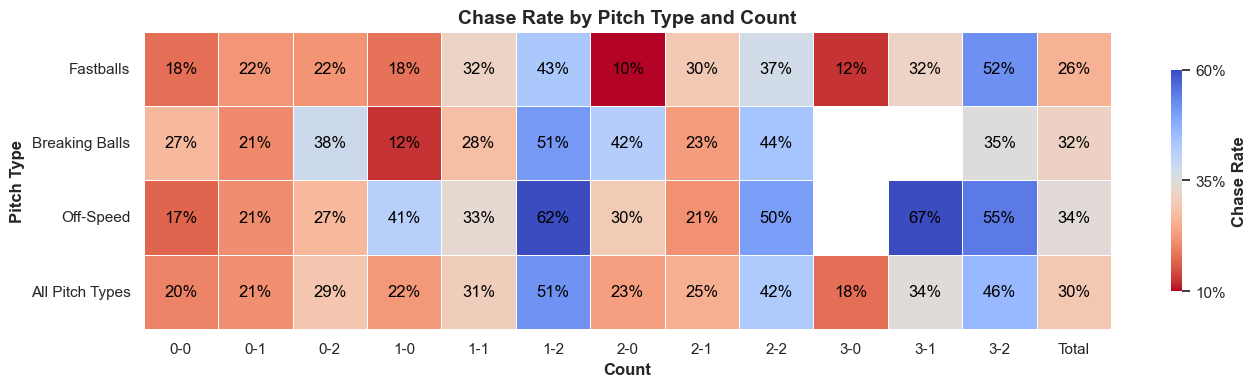

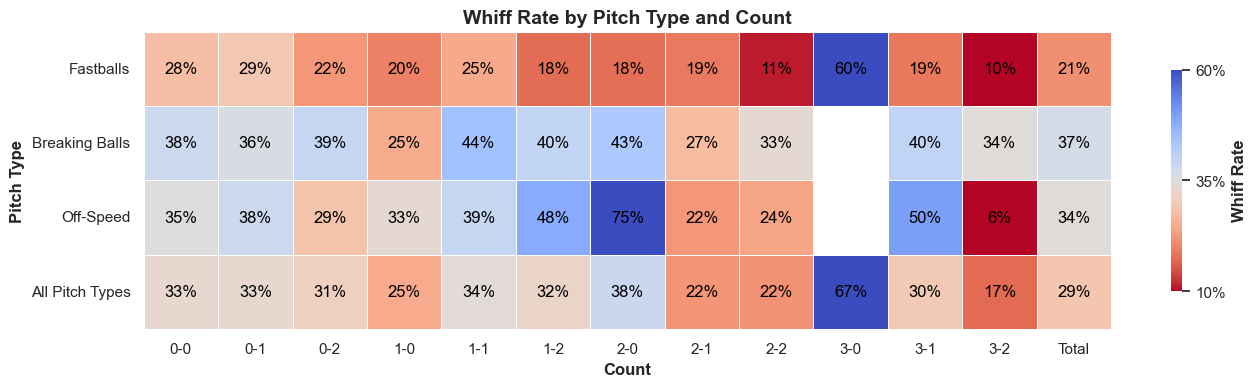

In [99]:
"""
Plots formatted heatmaps of chase and whiff rates by pitch type and count using Seaborn
Uses a reversed colormap to visually emphasize poor plate discipline (red = better, blue = worse)
Outputs are intended to show how hitters perform in various game situations and pitch types
These visualizations are suitable for inclusion in a portfolio or performance analysis report
"""

# Plot a formatted heatmap of metric values
def plot_metric_heatmap(data, title, label, filename=None):
    # Mask missing values
    mask = data.isna()

    # Reverse colormap: blue = high, red = low
    cmap = colormaps['coolwarm_r'].copy()
    cmap.set_bad('white')

    fig, ax = plt.subplots(figsize=(len(data.columns) * 1.2, len(data.index) * 1.2))
    sns.heatmap(
        data,
        cmap=cmap,
        annot=True,
        fmt='.0%',
        linewidths=0.5,
        square=True,
        vmin=0.1,
        vmax=0.6,
        cbar_kws={'label': label, 'shrink': 0.6, 'ticks': [0.1, 0.35, 0.6]},
        mask=mask,
        annot_kws={'color': 'black'}
    )

    # Format colorbar ticks and label
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticklabels(['10%', '35%', '60%'])
    colorbar.set_label(label, fontweight='bold', fontname='Arial')

    # Set plot labels
    plt.title(title, fontsize=14, fontweight='bold', fontname='Arial')
    plt.xlabel("Count", fontweight='bold', fontname='Arial')
    plt.ylabel("Pitch Type", fontweight='bold', fontname='Arial')

    # Save to file if specified
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Generate final visualizations
plot_metric_heatmap(chase_matrix, "Chase Rate by Pitch Type and Count", "Chase Rate", filename="chase_rate.png")
plot_metric_heatmap(whiff_matrix, "Whiff Rate by Pitch Type and Count", "Whiff Rate", filename="whiff_rate.png")